<a href="https://colab.research.google.com/github/Abyy98/T5Bee.W8/blob/main/Copy_of_Task2_Text_Classification_w8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [ ]:
!pip install tensorflow numpy pandas matplotlib seaborn nltk kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Download the Dataset

In [ ]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 76.7MB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ã_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [ ]:
print(df.head())
print(df.info())
print(df['label'].value_counts())

                                                text label
0  Go until jurong point, crazy.. Available only ...   ham
1                      Ok lar... Joking wif u oni...   ham
2  Free entry in 2 a wkly comp to win FA Cup fina...  spam
3  U dun say so early hor... U c already then say...   ham
4  Nah I don't think he goes to usf, he lives aro...   ham
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


check text length

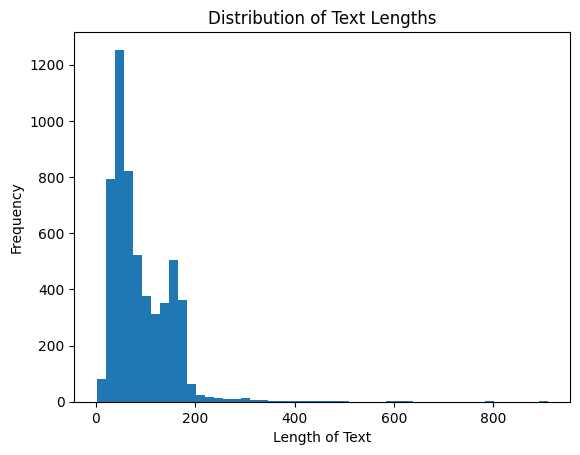

In [ ]:
df['text_length'] = df['text'].apply(len)
plt.hist(df['text_length'], bins=50)
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [ ]:
import pandas as pd

def filter_by_length(text, min_words=3, max_words=50):
    words = text.split()
    if min_words <= len(words) <= max_words:
        return text
    return None

df['filtered_text'] = df['text'].apply(lambda x: filter_by_length(x)).dropna()

print("Filtered texts by length:")
print(df['filtered_text'].head(5))


Filtered texts by length:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: filtered_text, dtype: object


In [ ]:
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')


stop_words = set(stopwords.words('english'))

print("Loaded English stopwords:")
print(stop_words)


Loaded English stopwords:
{'y', 'ain', 'again', "you've", 'your', 'her', "isn't", 'doing', 'in', 'most', 'shouldn', 'hadn', 'but', 'hasn', 'each', 'those', "hasn't", 'once', 'them', 'to', 'ma', 'under', 'down', 'our', 'yourself', 'his', 'on', 'too', 'be', 'few', 'shan', 'was', 'we', 'am', 'these', 'until', "you'll", 'are', 'my', 'about', "don't", 'couldn', 'below', 'you', 'then', 'why', 'o', "doesn't", 'up', 'their', 'the', 'before', 'some', 'been', "couldn't", "aren't", 'wouldn', "she's", 'yourselves', 'nor', 'doesn', "it's", 'after', 'above', 'were', 'because', 'both', 'it', 'other', 'which', 't', 'they', 'do', 'did', 'out', "shan't", 'being', 'itself', 'its', 'hers', 'off', 'yours', 'me', 'theirs', 'further', 'a', 'and', "hadn't", 'ours', 'more', 'with', 'same', 'mustn', 'isn', 'as', 'had', 'between', 'i', 'have', 'herself', 'an', 'can', 'wasn', "weren't", 'now', "wouldn't", "should've", 'only', 'how', 'aren', 'of', 'for', 'this', 'should', 'just', 'here', 'not', 'mightn', 'has', 'w

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import re

def clean_text(text):
    if isinstance(text, str):

        text = re.sub(r'http\S+', '', text)

        text = re.sub(r'[^A-Za-z\s]', '', text)

        text = text.lower()

        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""


df['clean_text_cleaned'] = df['filtered_text'].apply(clean_text)


print("Before cleaning:")
print(df['filtered_text'].head(5))
print("\nAfter cleaning:")
print(df['clean_text_cleaned'].head(5))



Before cleaning:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: filtered_text, dtype: object

After cleaning:
0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in a wkly comp to win fa cup final ...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: clean_text_cleaned, dtype: object


In [ ]:
import pandas as pd
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()

        words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(words)
    return ""


df['clean_text_no_stopwords'] = df['clean_text_cleaned'].apply(remove_stopwords)

print("\nAfter removing stopwords:")
print(df['clean_text_no_stopwords'].head(5))



After removing stopwords:
0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
Name: clean_text_no_stopwords, dtype: object


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


df['clean_text_lemmatized'] = df['clean_text_no_stopwords'].apply(lemmatize_text)


print("\nAfter lemmatization:")
print(df['clean_text_lemmatized'].head(5))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



After lemmatization:
0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: clean_text_lemmatized, dtype: object


In [ ]:
df.sample(10)

,text,label,text_length,filtered_text,clean_text_cleaned,clean_text_no_stopwords,clean_text_lemmatized,processed_text
3744,"Aight, let me know when you're gonna be around...",ham,68,"Aight, let me know when you're gonna be around...",aight let me know when youre gonna be around usf,aight let know youre gonna around usf,aight let know youre gon na around usf,aight let know youre gon na around usf
1336,"Sweet, we may or may not go to 4U to meet carl...",ham,82,"Sweet, we may or may not go to 4U to meet carl...",sweet we may or may not go to u to meet carlos...,sweet may may go u meet carlos gauge pattys in...,sweet may may go u meet carlos gauge patty int...,sweet may may go u meet carlos gauge patty int...
1522,I thk u dun haf 2 hint in e forum already lor....,ham,96,I thk u dun haf 2 hint in e forum already lor....,i thk u dun haf hint in e forum already lor co...,thk u dun haf hint e forum already lor cos tol...,thk u dun haf hint e forum already lor co told...,thk u dun haf hint e forum already lor co told...
2775,We confirm eating at esplanade?,ham,31,We confirm eating at esplanade?,we confirm eating at esplanade,confirm eating esplanade,confirm eating esplanade,confirm eating esplanade
1826,Dude. What's up. How Teresa. Hope you have bee...,ham,332,NaN,,,,
377,Well there's not a lot of things happening in ...,ham,149,Well there's not a lot of things happening in ...,well theres not a lot of things happening in l...,well theres lot things happening lindsay new y...,well there lot thing happening lindsay new yea...,well there lot thing happening lindsay new yea...
1215,that would be good ÂÃ_ I'll phone you tomo l...,ham,87,that would be good ÂÃ_ I'll phone you tomo l...,that would be good ill phone you tomo lunchtim...,would good ill phone tomo lunchtime shall orga...,would good ill phone tomo lunchtime shall orga...,would good ill phone tomo lunchtime shall orga...
4937,No it was cancelled yeah baby! Well that sound...,ham,129,No it was cancelled yeah baby! Well that sound...,no it was cancelled yeah baby well that sounds...,cancelled yeah baby well sounds important unde...,cancelled yeah baby well sound important under...,cancelled yeah baby well sound important under...
3856,No! But we found a diff farm shop to buy some ...,ham,85,No! But we found a diff farm shop to buy some ...,no but we found a diff farm shop to buy some c...,found diff farm shop buy cheese way back call,found diff farm shop buy cheese way back call,found diff farm shop buy cheese way back call
1129,So check your errors and if you had difficulti...,ham,64,So check your errors and if you had difficulti...,so check your errors and if you had difficulti...,check errors difficulties correction,check error difficulty correction,check error difficulty correction


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))


additional_stopwords = set(['u', 'im', 'ur', 'ltgt'])
stop_words.update(additional_stopwords)

lemmatizer = WordNetLemmatizer()


def filter_by_length(text, min_words=3, max_words=50):
    words = text.split()
    if min_words <= len(words) <= max_words:
        return text
    return None


def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^A-Za-z\s]', '', text)
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    return ""


def lemmatize_text(text):
    if isinstance(text, str):
        words = nltk.word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)
    return ""


def process_text(text):

    filtered_text = filter_by_length(text)
    if filtered_text is None:
        return ""

    cleaned_text = clean_text(filtered_text)

    no_stopwords_text = remove_stopwords(cleaned_text)

    lemmatized_text = lemmatize_text(no_stopwords_text)
    return lemmatized_text

df['processed_text'] = df['text'].apply(process_text)


print("\nProcessed texts:")
print(df[['text', 'processed_text']].head(5))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Processed texts:
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      processed_text  
0  go jurong point crazy available bugis n great ...  
1                              ok lar joking wif oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                    dun say early hor c already say  
4           nah dont think go usf life around though  


most_common_words processed_text:
[('call', 598), ('get', 381), ('go', 296), ('free', 275), ('dont', 274), ('ok', 251), ('know', 249), ('got', 248), ('come', 238), ('day', 237), ('like', 233), ('ill', 233), ('good', 225), ('time', 220), ('text', 215), ('want', 202), ('love', 195), ('send', 183), ('need', 170), ('one', 168)]


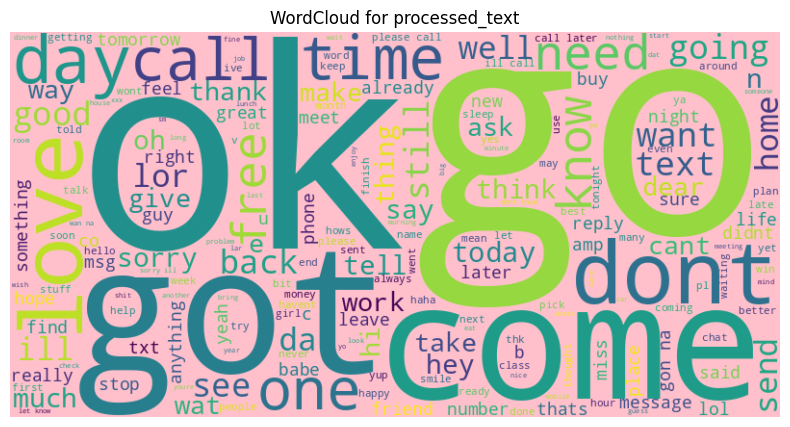

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_freq(column_name):

    all_text = ' '.join(df[column_name].dropna())


    words = all_text.split()


    word_freq = Counter(words)


    most_common_words = word_freq.most_common(20)
    print(f"most_common_words {column_name}:")
    print(most_common_words)


    wordcloud = WordCloud(width=800, height=400, background_color='Pink').generate(all_text)


    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {column_name}')
    plt.show()

column_to_analyze = 'processed_text'


plot_word_freq(column_to_analyze)


In [ ]:
df.sample(10)

,text,label,text_length,filtered_text,clean_text_cleaned,clean_text_no_stopwords,clean_text_lemmatized,processed_text
3619,I meant as an apology from me for texting you ...,ham,102,I meant as an apology from me for texting you ...,i meant as an apology from me for texting you ...,meant apology texting get drugs ltgt night,meant apology texting get drug ltgt night,meant apology texting get drug night
935,Then dun wear jeans lor...,ham,26,Then dun wear jeans lor...,then dun wear jeans lor,dun wear jeans lor,dun wear jean lor,dun wear jean lor
4087,He needs to stop going to bed and make with th...,ham,63,He needs to stop going to bed and make with th...,he needs to stop going to bed and make with th...,needs stop going bed make fucking dealing,need stop going bed make fucking dealing,need stop going bed make fucking dealing
865,Congratulations ur awarded either a yrs supply...,spam,163,Congratulations ur awarded either a yrs supply...,congratulations ur awarded either a yrs supply...,congratulations ur awarded either yrs supply c...,congratulation ur awarded either yr supply cd ...,congratulation awarded either yr supply cd vir...
5174,Water logging in desert. Geoenvironmental impl...,ham,73,Water logging in desert. Geoenvironmental impl...,water logging in desert geoenvironmental impli...,water logging desert geoenvironmental implicat...,water logging desert geoenvironmental implication,water logging desert geoenvironmental implication
2511,Er yep sure. Props?,ham,19,Er yep sure. Props?,er yep sure props,er yep sure props,er yep sure prop,er yep sure prop
4903,"no, i *didn't* mean to post it. I wrote it, an...",ham,433,NaN,,,,
4280,"Wn u r hurt by d prsn who s close 2 u, do figh...",ham,170,"Wn u r hurt by d prsn who s close 2 u, do figh...",wn u r hurt by d prsn who s close u do fight w...,wn u r hurt prsn close u fight wit dem coz som...,wn u r hurt prsn close u fight wit dem coz som...,wn r hurt prsn close fight wit dem coz somtime...
3158,Are you up for the challenge? I know i am :) h...,ham,62,Are you up for the challenge? I know i am :) h...,are you up for the challenge i know i am,challenge know,challenge know,challenge know
279,All done? All handed in? Celebrations in full ...,ham,56,All done? All handed in? Celebrations in full ...,all done all handed in celebrations in full sw...,done handed celebrations full swing yet,done handed celebration full swing yet,done handed celebration full swing yet


# here have nan value because text length not same so return nan
# so i drop this nan

In [ ]:
df.dropna()

,text,label,text_length,filtered_text,clean_text_cleaned,clean_text_no_stopwords,clean_text_lemmatized,processed_text
0,"Go until jurong point, crazy.. Available only ...",ham,111,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ham,29,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,ok lar joking wif u oni,ok lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,173,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,free entry wkly comp win fa cup final tkts st ...,free entry wkly comp win fa cup final tkts st ...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,ham,67,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say,u dun say early hor u c already say,dun say early hor c already say
4,"Nah I don't think he goes to usf, he lives aro...",ham,79,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,nah dont think go usf life around though,nah dont think go usf life around though
...,...,...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,181,This is the 2nd time we have tried 2 contact u...,this is the nd time we have tried contact u u ...,nd time tried contact u u pound prize claim ea...,nd time tried contact u u pound prize claim ea...,nd time tried contact pound prize claim easy c...
5568,Will Ã_ b going to esplanade fr home?,ham,38,Will Ã_ b going to esplanade fr home?,will b going to esplanade fr home,b going esplanade fr home,b going esplanade fr home,b going esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",ham,75,"Pity, * was in mood for that. So...any other s...",pity was in mood for that soany other suggestions,pity mood soany suggestions,pity mood soany suggestion,pity mood soany suggestion
5570,The guy did some bitching but I acted like i'd...,ham,125,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like id ...,guy bitching acted like id interested buying s...,guy bitching acted like id interested buying s...,guy bitching acted like id interested buying s...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])

sequences = tokenizer.texts_to_sequences(df['processed_text'])
max_length = 100

In [ ]:
X = pad_sequences(sequences, maxlen=max_length)

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (4457, 100)
Shape of X_test: (1115, 100)
Shape of y_train: (4457,)
Shape of y_test: (1115,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()

model.add(Input(shape=(max_length,)))

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=100,
                    input_length=max_length))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))

model.add(LSTM(units=32))
model.add(Dropout(0.5))


model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=len(label_encoder.classes_), activation='Sigmoid'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │         760,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 866,150 (3.30 MB)

 Trainable params: 866,150 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [ ]:
# batch_size = 64
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))


test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

test_dataset = test_dataset.batch(batch_size)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=64,
                    callbacks=[early_stopping])


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.7964 - loss: 0.4956 - val_accuracy: 0.9709 - val_loss: 0.1329
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.9528 - loss: 0.1432 - val_accuracy: 0.9753 - val_loss: 0.0897
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 345ms/step - accuracy: 0.9821 - loss: 0.0670 - val_accuracy: 0.9832 - val_loss: 0.0782
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.9863 - loss: 0.0498 - val_accuracy: 0.9798 - val_loss: 0.1233
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.9934 - loss: 0.0186 - val_accuracy: 0.9787 - val_loss: 0.1375
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - accuracy: 0.9941 - loss: 0.0148 - val_accuracy: 0.9753 - val_loss: 0.1457


# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9838 - loss: 0.0534
Test loss: 0.0713261291384697
Test accuracy: 0.9784753322601318


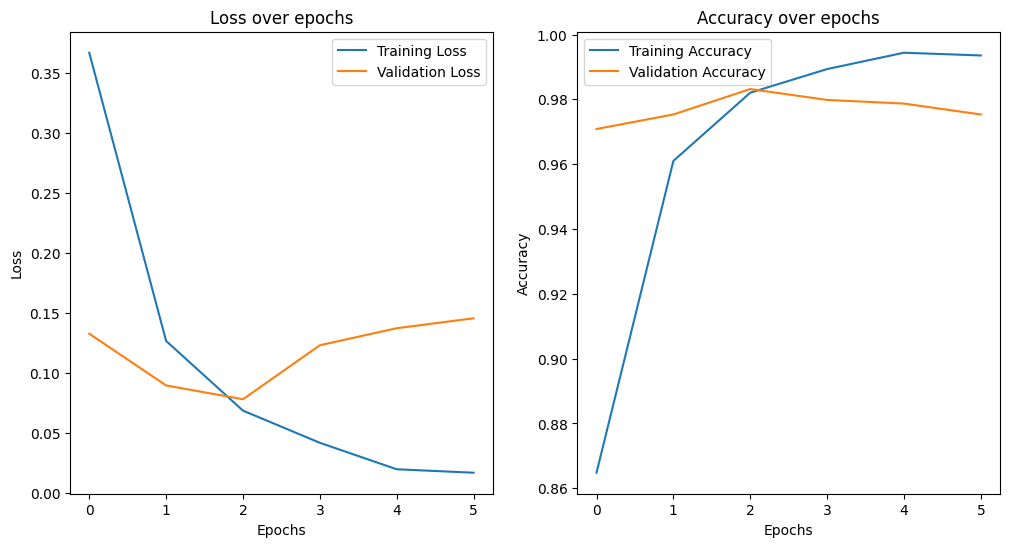

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [ ]:
test_samples = [
    "Congratulations! You've won a $1000 gift card. Click here to claim your prize now!",
    "Let's meet at 3 PM tomorrow."
]


sequences = tokenizer.texts_to_sequences(test_samples)
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length)

predictions = model.predict(padded_sequences)

predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_text = label_encoder.inverse_transform(predicted_labels)


for text, prediction in zip(test_samples, predicted_labels_text):
    print(f"Text: {text}")
    print(f"Prediction: {prediction}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Text: Congratulations! You've won a $1000 gift card. Click here to claim your prize now!
Prediction: spam

Text: Let's meet at 3 PM tomorrow.
Prediction: ham



# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

1.I cleaned the text by removing numbers and symbols, converting to lowercase, and removing common words.
also remove this words 'u', 'im', 'ur', 'ltgt' Because it lacks clear meaning

**1.2.I created separate columns for each preprocessing step: 'text_length', 'filtered_text', 'clean_text_cleaned', 'clean_text_no_stopwords', and 'clean_text_lemmatized'. I then combined all these columns into a single column named 'processed_text' for further processing. I also created a word cloud to visualize the most common words and get a clearer understanding of the data.**

In [ ]:
df.columns

Index(['text', 'label', 'text_length', 'filtered_text', 'clean_text_cleaned',
       'clean_text_no_stopwords', 'clean_text_lemmatized', 'processed_text'],
      dtype='object')

** 2.I chose a sequential model with an embedding layer and Bidirectional LSTM to capture semantic relationships and context in the text.**

 3.I used 64 units in LSTM and an embedding dimension of 100, which are common values that balance complexity and efficiency.


 4.I used accuracy as it is a straightforward and effective measure of overall performance.

5.
The model shows signs of overfitting. The model's accuracy on the training set is high, but the validation accuracy is lower, indicating that the model performs well on the training data but poorly on the unseen data.

6.To reduce overfitting, I have added dropout layers. To address underfitting, you can increase the model complexity.

# "Now I see it as good for me."